In [1]:
import sys

sys.path.append('.')

import ntpath
import os
import tqdm
import torch
import numpy as np
import json

from collections import defaultdict
from torch.utils.data import DataLoader

from data.aug import ops
from data.dataset import DOTA
from data.aug.compose import Compose

from model.rdd import RDD
from model.backbone import resnet

from utils.box.bbox_np import xywha2xy4, xy42xywha
from utils.box.rbbox_np import rbbox_batched_nms
from utils.parallel import CustomDetDataParallel

In [2]:
!ls image-sets

dataset.json  test  test-768.json  test.json  train.json  val.json


In [3]:
def create_dataset_from_folder(dir_dataset):
    pairs = []
    for filename in os.listdir(dir_dataset):
        img = os.path.join(dir_dataset, filename)
        anno = None
        pairs.append([img, anno])
    
    os.makedirs('image-sets', exist_ok=True)
    json.dump(pairs, open(os.path.join('image-sets', 'dataset.json'), 'wt'), indent=2)
    
dir_dataset = './images/test'
create_dataset_from_folder(dir_dataset)

In [4]:
dir_output = './predictions'
path_bar_predictions = os.path.join(dir_output, 'prediction.txt')
path_bar_predictions_drew_bbs = os.path.join(dir_output, 'bar_bbs/')
path_cropped_bars_predictions = os.path.join(dir_output, 'cropped_bars/')

In [5]:
batch_size = 12
num_workers = 4
conf_thresh = 0.5
nms_thresh = 0.5
image_size = 768
device_ids = [0]
torch.cuda.set_device(device_ids[0])

backbone = resnet.resnet101
dir_weight = os.path.join('save/weight/93000.pth')

aug = Compose([ops.PadSquare(), ops.Resize(image_size)])
dataset = DOTA('.', 'dataset', aug)
print(f'predicting {len(dataset)} files')

loader = DataLoader(dataset, batch_size, num_workers=num_workers, pin_memory=True, collate_fn=dataset.collate)
num_classes = len(dataset.names)

prior_box = {
    'strides': [8, 16, 32, 64, 128],
    'sizes': [3] * 5,
    'aspects': [[1, 2, 4, 8]] * 5,
    'scales': [[2 ** 0, 2 ** (1 / 3), 2 ** (2 / 3)]] * 5,
    'old_version': False
}
cfg = {
    'prior_box': prior_box,
    'num_classes': num_classes,
    'extra': 2,
    'conf_thresh': conf_thresh,
    'nms_thresh': nms_thresh
}

model = RDD(backbone(fetch_feature=True), cfg)
model.build_pipe(shape=[2, 3, image_size, image_size])
model.restore(dir_weight)
if len(device_ids) > 1:
    model = CustomDetDataParallel(model, device_ids)
model.cuda()
model.eval()

predicting 7245 files


RDD(
  (backbone): Backbone(
    (head): Sequential(
      (0): Conv2d(
        (module): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      )
      (1): BatchNorm2d(
        (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (body): Sequential(
          (0): Conv2d(
            (module): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1): BatchNorm2d(
            (module): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (2): ReLU(inplace=True)
          (3): Conv2d(
            (module): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (4): BatchNorm2d(
            (module): BatchNorm2d(64, 

In [6]:
count_predicted, count_not_predicted = 0, 0
ret_raw = defaultdict(list)    
for images, targets, infos in tqdm.tqdm(loader):
    images = images.cuda() / 255
    dets = model(images)
    for (det, info) in zip(dets, infos):
        if det:
            count_predicted += 1
            bboxes, scores, labels = det
            bboxes = bboxes.cpu().numpy()
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            x, y, w, h = 0, 0, info['shape'][1], info['shape'][0]
            fname = ntpath.basename(info['img_path'])
            x, y, w, h = int(x), int(y), int(w), int(h)
            long_edge = max(w, h)
            pad_x, pad_y = (long_edge - w) // 2, (long_edge - h) // 2
            bboxes = np.stack([xywha2xy4(bbox) for bbox in bboxes])
            bboxes *= long_edge / image_size
            bboxes -= [pad_x, pad_y]
            bboxes += [x, y]
            bboxes = np.stack([xy42xywha(bbox) for bbox in bboxes])
            ret_raw[fname].append([bboxes, scores, labels])
        else:
            count_not_predicted += 1
            ret_raw[fname].append([np.zeros((1,5)), np.zeros((1,)), np.zeros((1,))])
    break
print(f'{count_predicted} files with found object, {count_not_predicted} with no object found')

  0%|          | 0/604 [00:02<?, ?it/s]

11 files with found object, 1 with no object found


In [7]:
print('merging results...')
ret = []

for fname, dets in ret_raw.items():
    bboxes, scores, labels = zip(*dets)
    bboxes = np.concatenate(list(bboxes))
    scores = np.concatenate(list(scores))
    labels = np.concatenate(list(labels))
    keeps = rbbox_batched_nms(bboxes, scores, labels, nms_thresh)
    ret.append([fname, [bboxes, scores[keeps], labels[keeps]]])

print('converting to submission format...')
ret_save = defaultdict(list)
for fname, (bboxes, scores, labels) in ret:
    for bbox, score, label in zip(bboxes, scores, labels):
        #         bbox = xywha2xy4(bbox).ravel()
        line = '%s %.12f %.1f %.1f %.1f %.1f %.1f' % (fname, score, *bbox)
        ret_save[dataset.label2name[label]].append(line)

print('saving...')
os.makedirs(os.path.dirname(path_bar_predictions), exist_ok=True)
for name, dets in ret_save.items():
    with open(os.path.join(path_bar_predictions), 'wt') as f:
        f.write('\n'.join(dets))

print('finished')

merging results...
converting to submission format...
saving...
finished


In [8]:
# !cat predictions/prediction.txt
!ls predictions

bar_bbs  cropped_bars  predictions-first  predictions-second  prediction.txt


In [117]:
from PIL import Image, ImageDraw
import math 
import matplotlib.pyplot as plt

def rotate_around_point(point, radians, origin):
    x, y = point
    ox, oy = origin
    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)
    return qx, qy

os.makedirs(path_bar_predictions_drew_bbs, exist_ok=True)
os.makedirs(os.path.dirname(path_cropped_bars_predictions), exist_ok=True)

with open(path_bar_predictions) as f:
    lines = f.readlines()
    predicted_bbs = dict()
    for i, l in enumerate(lines):
        parts = l.replace('\n','').split(' ')
        jpg_name = parts[0]
        bb = tuple(float(x) for x in parts[2:])
        if jpg_name not in predicted_bbs:
            predicted_bbs[jpg_name] = []
        predicted_bbs[jpg_name].append(bb)
    
    for jpg_name in predicted_bbs:
        img = Image.open(os.path.join(dir_dataset, jpg_name))
        default_img = img.copy()
        draw = ImageDraw.Draw(img)
        for i, bb in enumerate(predicted_bbs[jpg_name]):
            
            coords = xywha2xy4(bb)
            
            draw.line((*coords[0], *coords[1]), fill='red', width=20)
            draw.line((*coords[1], *coords[2]), fill='red', width=20)
            draw.line((*coords[2], *coords[3]), fill='red', width=20)
            draw.line((*coords[3], *coords[0]), fill='red', width=20)
            
            x, y, w, h, angle = bb
            width, height = img.size
            if w < h:
                angle -= 90
                w, h = h, w
            
            rotated_img = default_img.rotate(angle)
            x1, y1 = rotate_around_point((x,y), math.radians(angle), (width//2, height//2))
            cropped_bar = rotated_img.crop((x1-w//2, y1-h//2, x1+w//2, y1+h//2))
            
            bar_jpg_name = f'{i}__{jpg_name}'
            cropped_bar.save(os.path.join(path_cropped_bars_predictions, bar_jpg_name))
            
        img.save(os.path.join(path_bar_predictions_drew_bbs, jpg_name))
        


In [116]:
path_bar_predictions_drew_bbs, path_cropped_bars_predictions

('./predictions/bar_bbs/', './predictions/cropped_bars/')

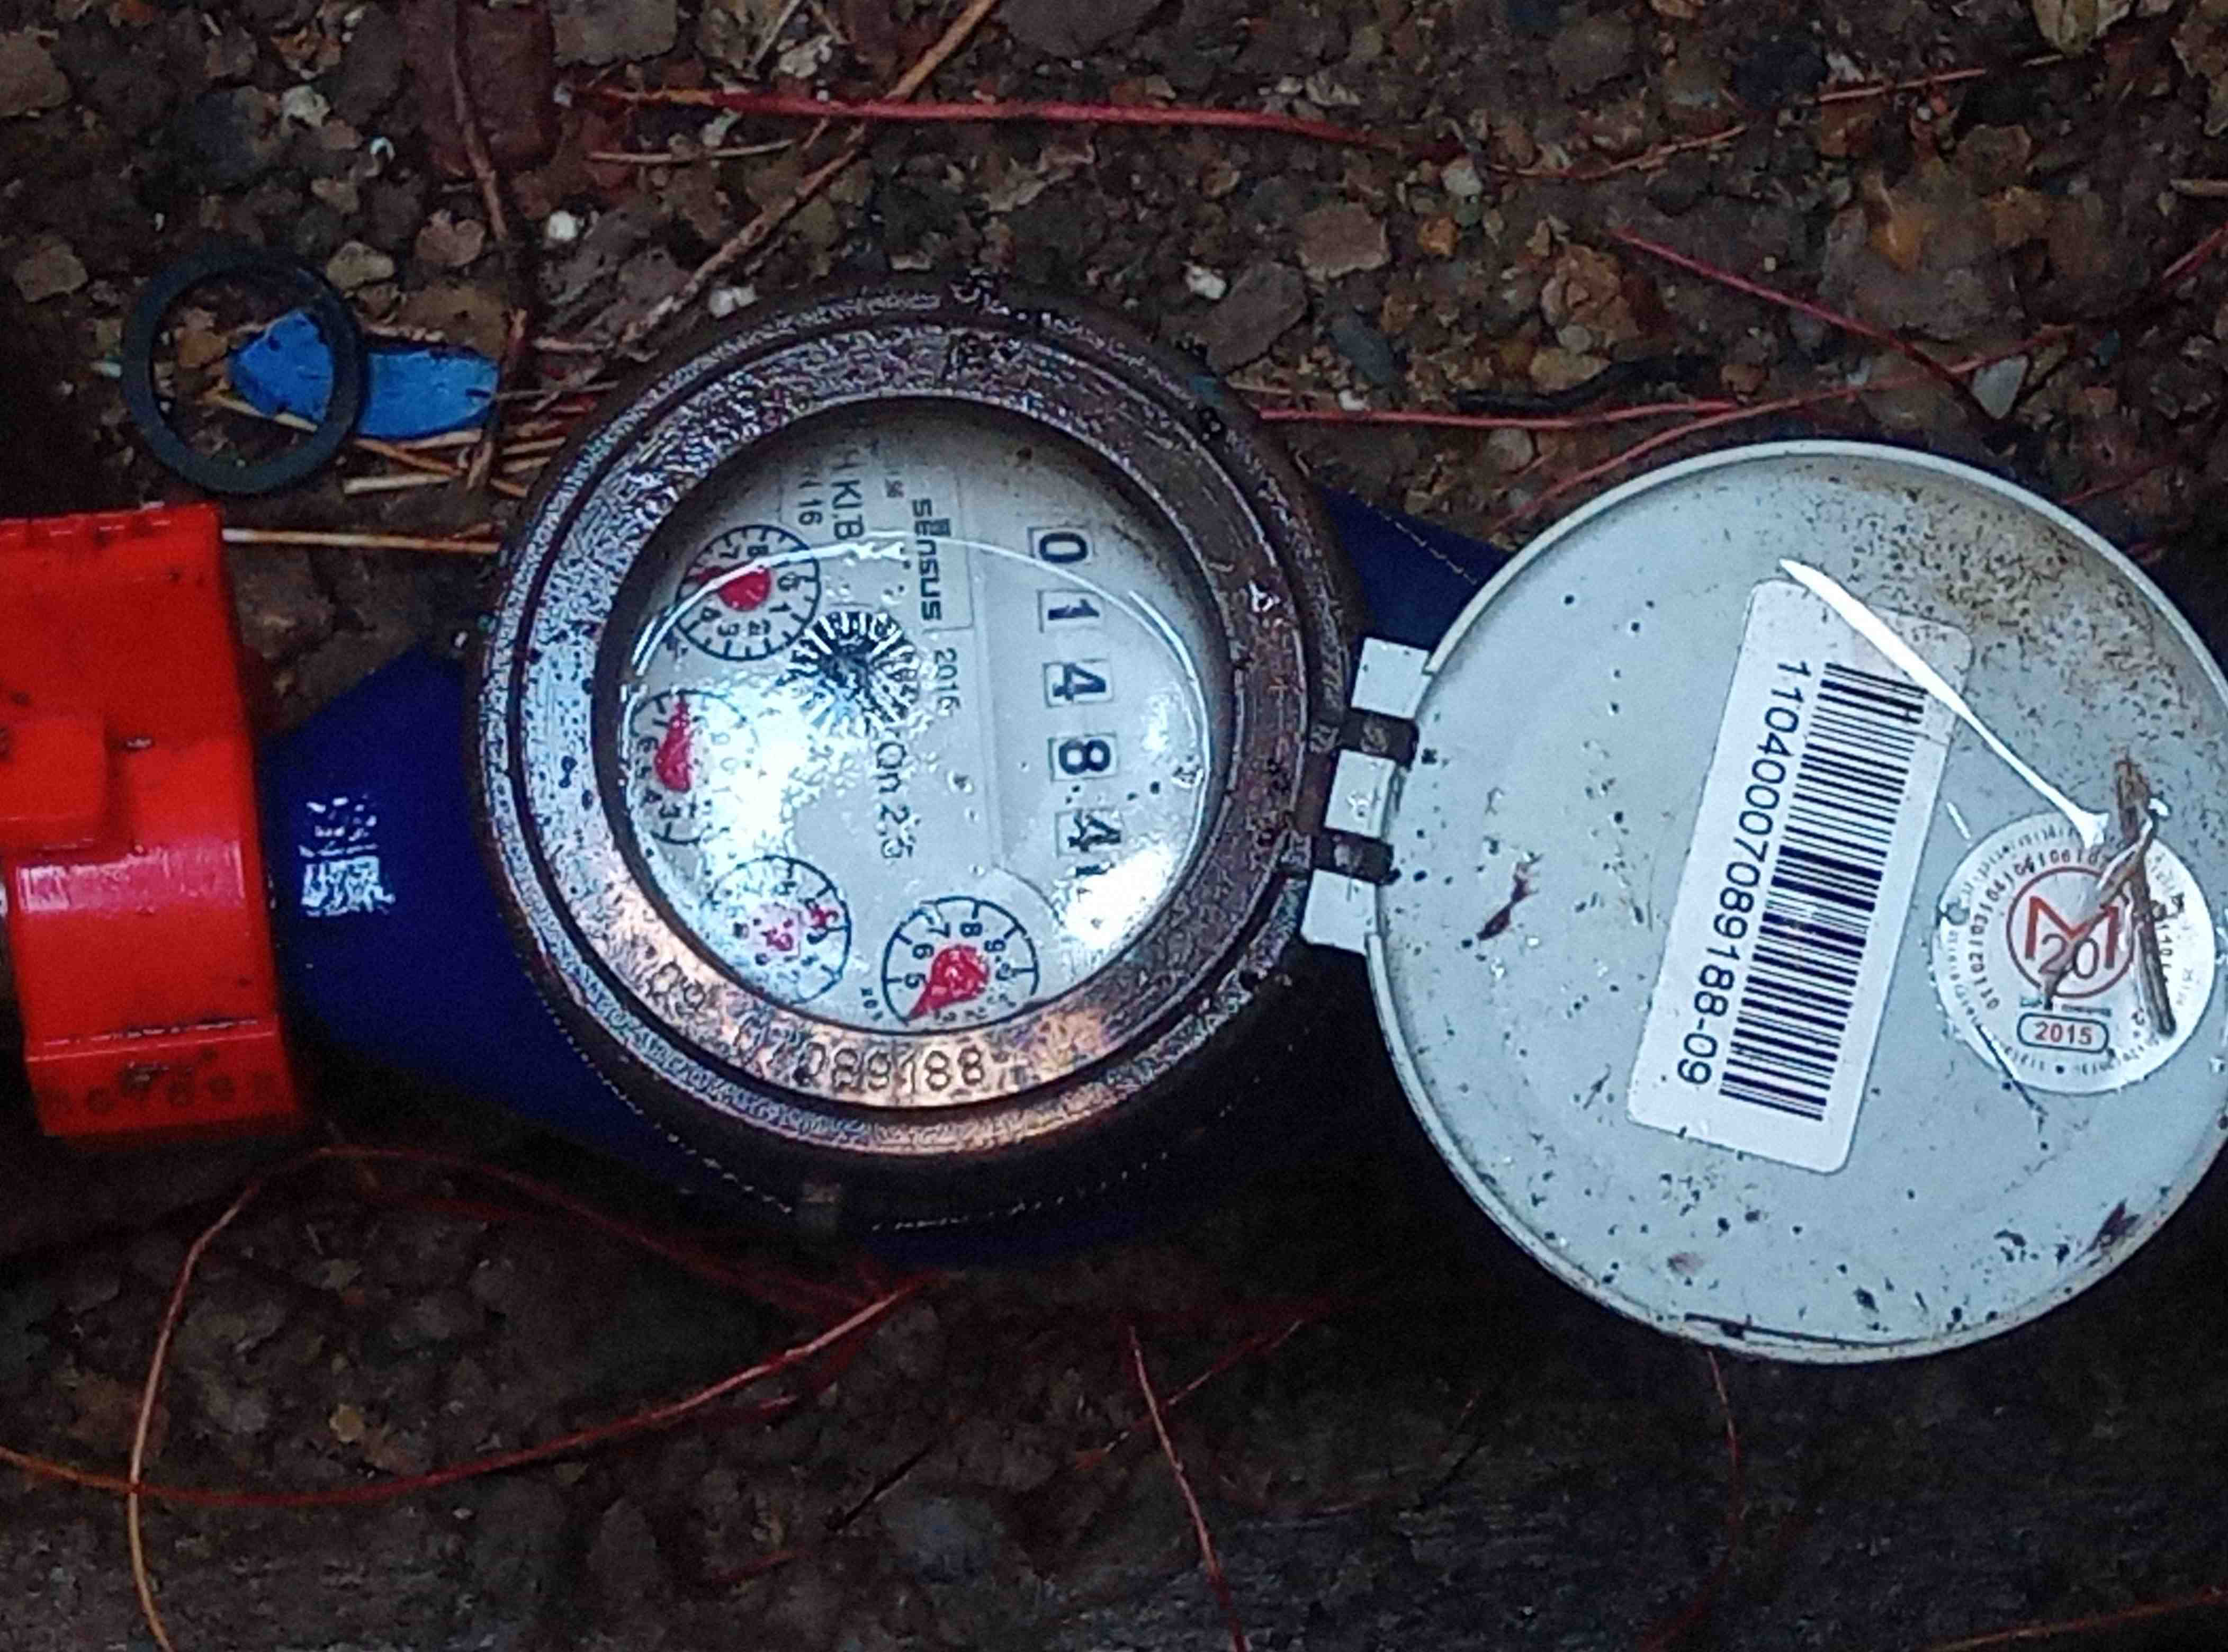

In [187]:
rotated_img